In [1]:
# ============================================
# CÉLULA 1 — Setup do projeto
# ============================================

from pathlib import Path

ROOT = Path("BRACOL_REVIEWED")
assert ROOT.exists(), "❌ Pasta BRACOL_REVIEWED não encontrada"

print("✅ Dataset encontrado em:", ROOT.resolve())
for p in ROOT.iterdir():
    print(" -", p.name)


✅ Dataset encontrado em: D:\PROJETO CAFEEIRO 2\BRACOL_REVIEWED
 - data.yaml
 - README.dataset.txt
 - README.roboflow.txt
 - test
 - train
 - valid


In [2]:
# ============================================
# CÉLULA 2 — Leitura do data.yaml (compatível)
# ============================================

data_yaml = ROOT / "data.yaml"
assert data_yaml.exists(), "❌ data.yaml não encontrado"

data_cfg = {}
with open(data_yaml, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        if ":" in line:
            k, v = line.split(":", 1)
            data_cfg[k.strip()] = v.strip()

nc = int(data_cfg["nc"])
names = eval(data_cfg["names"])

print("Número de classes:", nc)
print("Classes:", names)
print("Train:", data_cfg.get("train"))
print("Val:", data_cfg.get("val"))
print("Test:", data_cfg.get("test"))


Número de classes: 4
Classes: ['Cercospora', 'Miner', 'Phoma', 'Rust']
Train: ../train/images
Val: ../valid/images
Test: ../test/images


In [3]:
# ============================================
# CÉLULA 3 — Estatísticas do dataset
# ============================================

from collections import Counter

splits = ["train", "valid", "test"]
stats = {}
bbox_counter = Counter()
class_counter = Counter()

for split in splits:
    img_dir = ROOT / split / "images"
    lbl_dir = ROOT / split / "labels"

    images = list(img_dir.glob("*"))
    labels = list(lbl_dir.glob("*.txt"))

    stats[split] = {"images": len(images), "labels": len(labels)}

    for lbl in labels:
        for line in lbl.read_text().splitlines():
            if not line.strip():
                continue
            cls = int(line.split()[0])
            bbox_counter[split] += 1
            class_counter[(split, cls)] += 1

print("📊 Estatísticas:")
for s in stats:
    print(s, stats[s])

print("\n📦 BBoxes por split:", dict(bbox_counter))
print("\n🦠 Distribuição por classe:")
for split in splits:
    print(split, {names[c]: class_counter[(split, c)] for c in range(nc)})


📊 Estatísticas:
train {'images': 1213, 'labels': 1213}
valid {'images': 351, 'labels': 351}
test {'images': 180, 'labels': 180}

📦 BBoxes por split: {'train': 5798, 'valid': 1580, 'test': 848}

🦠 Distribuição por classe:
train {'Cercospora': 133, 'Miner': 171, 'Phoma': 1310, 'Rust': 4184}
valid {'Cercospora': 39, 'Miner': 111, 'Phoma': 254, 'Rust': 1176}
test {'Cercospora': 29, 'Miner': 59, 'Phoma': 107, 'Rust': 653}


In [4]:
# ============================================
# CÉLULA 4 — Tamanho das bboxes
# ============================================

import numpy as np

areas = []

for split in splits:
    for lbl in (ROOT / split / "labels").glob("*.txt"):
        for line in lbl.read_text().splitlines():
            if not line.strip():
                continue
            _, _, _, w, h = map(float, line.split())
            areas.append(w * h)

areas = np.array(areas)

print("Total de bboxes:", len(areas))
print("Área — min | mediana | p95 | max:",
      areas.min(), np.median(areas), np.percentile(areas, 95), areas.max())

print("⚠️ Manchas pequenas → imgsz alto recomendado (≥768)")


Total de bboxes: 8226
Área — min | mediana | p95 | max: 8.511543273925782e-08 0.0018120115995407104 0.021382570266723633 0.129241943359375
⚠️ Manchas pequenas → imgsz alto recomendado (≥768)


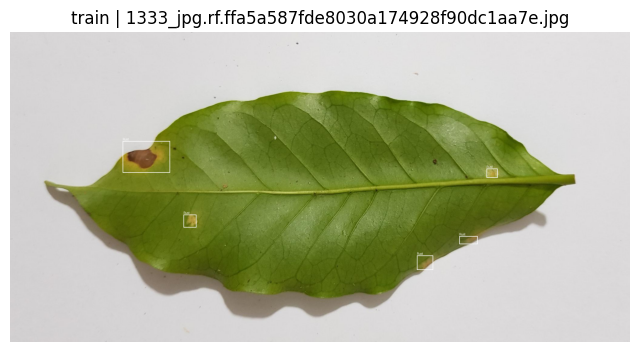

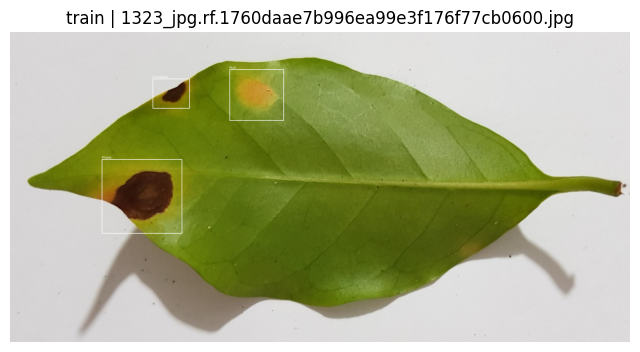

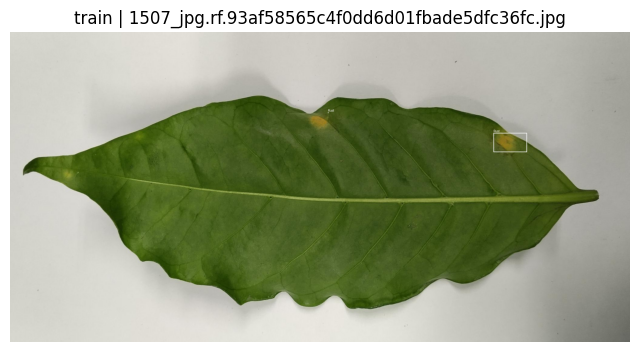

In [5]:
# ============================================
# CÉLULA 5 — Visualização das labels (PIL)
# ============================================

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random

def yolo_to_xyxy(x, y, w, h, W, H):
    cx, cy = x * W, y * H
    bw, bh = w * W, h * H
    return int(cx - bw/2), int(cy - bh/2), int(cx + bw/2), int(cy + bh/2)

def show_samples(split="train", n=3):
    img_dir = ROOT / split / "images"
    lbl_dir = ROOT / split / "labels"

    imgs = list(img_dir.glob("*"))
    random.shuffle(imgs)

    for img_path in imgs[:n]:
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        W, H = img.size

        label_path = lbl_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            for line in label_path.read_text().splitlines():
                if not line.strip():
                    continue
                cls, x, y, w, h = map(float, line.split())
                x1, y1, x2, y2 = yolo_to_xyxy(x, y, w, h, W, H)
                draw.rectangle([x1, y1, x2, y2], outline="white", width=2)
                draw.text((x1, max(0, y1-12)), names[int(cls)], fill="white")

        plt.figure(figsize=(8,5))
        plt.title(f"{split} | {img_path.name}")
        plt.imshow(img)
        plt.axis("off")
        plt.show()

show_samples("train", 3)


In [6]:
# ============================================
# CÉLULA 6 — YOLO + GPU
# ============================================

!pip install -q ultralytics

from ultralytics import YOLO
import torch

print("CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ GPU não detectada, usando CPU")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


CUDA disponível: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [12]:
# ============================================
# CÉLULA 7 — Treinamento YOLO (GPU)
# ============================================

device = 0 if torch.cuda.is_available() else "cpu"

model = YOLO("yolov8n.pt")

model.train(
    data=str(ROOT / "data.yaml"),
    epochs=80,
    imgsz=768,
    batch=-1,
    patience=15,
    close_mosaic=10,
    device=device,
    workers=2
)


New https://pypi.org/project/ultralytics/8.4.8 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.253  Python-3.12.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=BRACOL_REVIEWED\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=F

KeyboardInterrupt: 

In [ ]:
# ============================================
# CÉLULA 8 — Avaliação
# ============================================

print("🔍 Validação:")
model.val(split="val", device=device)

print("\n🧪 Teste:")
model.val(split="test", device=device)


🔍 Validação:
Ultralytics 8.3.253  Python-3.12.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 390.6192.3 MB/s, size: 105.0 KB)
val: Scanning D:\PROJETO CAFEEIRO 2\BRACOL_REVIEWED\valid\labels.cache... 351 images, 55 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 351/351  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 5.3it/s 4.1s0.1s
                   all        351       1580       0.51      0.585      0.555        0.3
            Cercospora         25         39      0.316      0.166      0.214      0.117
                 Miner         69        111      0.714      0.856      0.809      0.547
                 Phoma        134        254      0.478      0.681      0.638      0.352
                  Rust        144       1176      0.531      0.637      0.558      0.18

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018038D57290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       


0: 384x768 (no detections), 13.3ms
1: 384x768 (no detections), 13.3ms
2: 384x768 (no detections), 13.3ms
3: 384x768 2 Phomas, 2 Rusts, 13.3ms
4: 384x768 2 Phomas, 1 Rust, 13.3ms
5: 384x768 (no detections), 13.3ms
Speed: 2.2ms preprocess, 13.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 768)


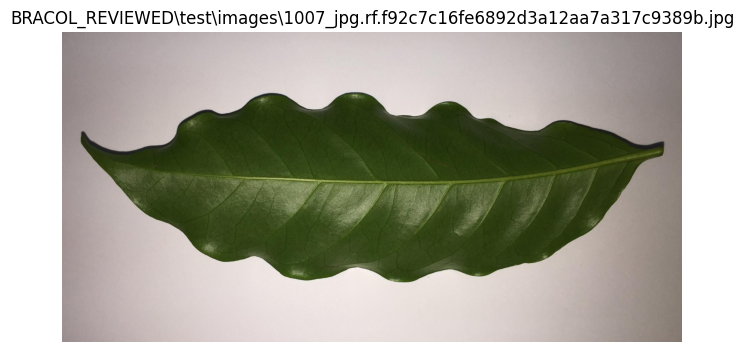

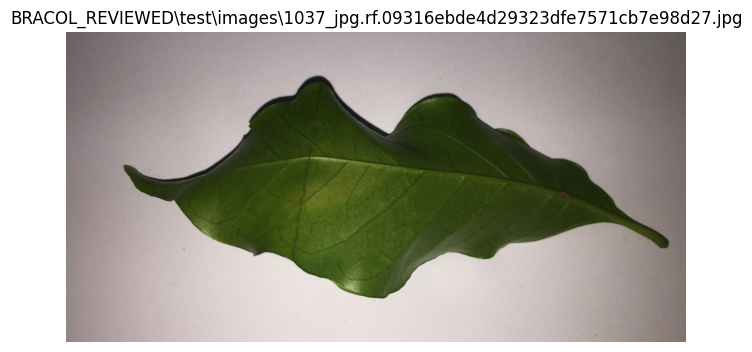

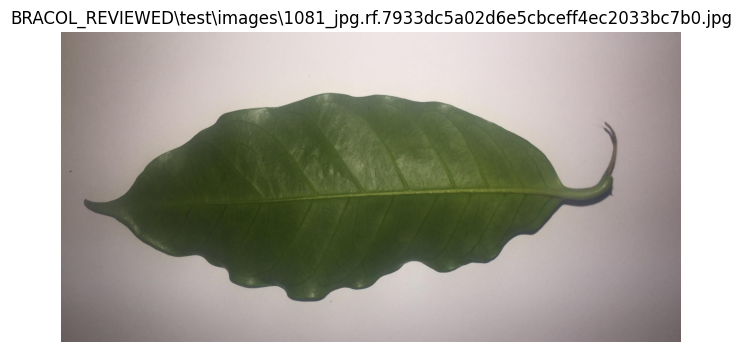

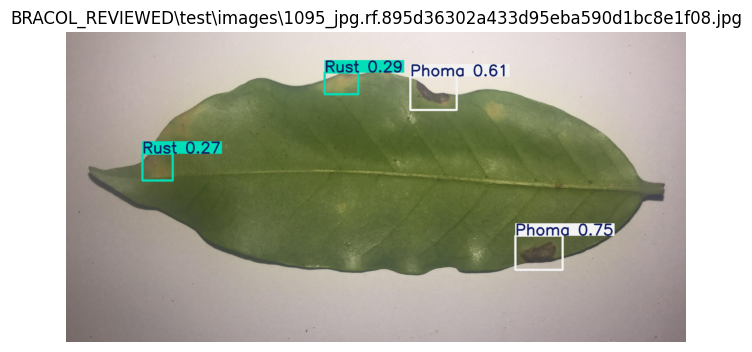

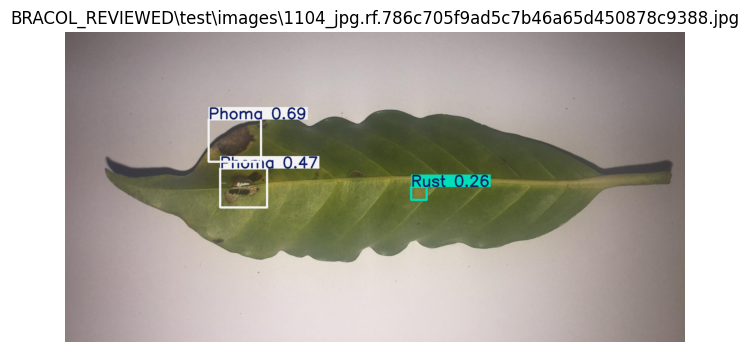

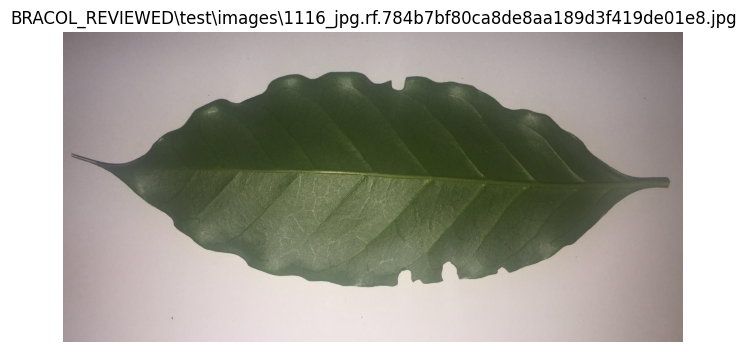

In [9]:
# ============================================
# CÉLULA 9 — Inferência
# ============================================

from PIL import Image
import matplotlib.pyplot as plt

test_imgs = list((ROOT / "test" / "images").glob("*"))[:6]

results = model.predict(
    source=[str(p) for p in test_imgs],
    imgsz=768,
    conf=0.25,
    iou=0.5,
    device=device
)

for r in results:
    img = Image.fromarray(r.plot()[:, :, ::-1])
    plt.figure(figsize=(8,5))
    plt.title(r.path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [10]:
# ============================================
# CÉLULA 10 — Exportação
# ============================================

model.export(format="onnx", opset=12)

print("""
✔ Pipeline completo
✔ GPU utilizada automaticamente
✔ Compatível com ambiente local ou Colab
✔ Pronto para ajuste fino ou produção
""")


Ultralytics 8.3.253  Python-3.12.10 torch-2.5.1+cu121 CPU (Intel Core Ultra 7 155H)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'D:\PROJETO CAFEEIRO 2\runs\detect\train2\weights\best.pt' with input shape (1, 3, 768, 768) BCHW and output shape(s) (1, 8, 12096) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.10 environment at: c:\Users\fpf\AppData\Local\Programs\Python\Python312
Resolved 15 packages in 1.48s
Prepared 8 packages in 2m 26s
Installed 8 packages in 8.27s
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.20.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.82
 + packaging==26.0
 + pyreadline3==3.5.4

requirements: AutoUpdate success  159.0s
WARNING requirements: Restart runtime or rerun command for updates to take effect